# BDT 

##### author: G. Räuber, 2024


## Content

In this notebook, we will follow several steps:
* Read a dataset (created with dataset/create_pkl.py)
* Define two different classes
* Define the input features
* Define test and training sets
* Fit a BDT on the training set, and then test its
    * Performance - compute a ROC curve
    * Reproducibility - look at potential overfitting issues
* Plot the BDT output


### Read dataset

Read the Dataset that we created


In [1]:
# Look what is the name of your .pkl file
!ls ../dataset

create_pkl.py                 dataset_2classes_features.pdf
dataset_2classes.pkl


In [2]:
# Read the Dataframe:
import pandas as pd
df=pd.read_pickle('../dataset/dataset_2classes.pkl')

# Print the Dataframe
print(df)

              a         b          c    d         e         f    g         h  \
0      3.863403  0.778973  12.946646  489  0.871213  0.033967  227  0.981583   
1      5.046944 -0.442038  23.305970  509  0.600349  3.773768  234  0.513771   
2      6.446498  1.500218  17.340156  504  2.235587  0.166467  251  2.038727   
3      7.555237  0.227320   7.548010  486  3.726162  1.393235  251  0.522864   
4      5.849820  1.143522   8.982487  477  7.757577  0.414826  239  2.865683   
...         ...       ...        ...  ...       ...       ...  ...       ...   
99995  5.291775 -0.449244   1.298263  460  7.275139  0.676796  280  1.019964   
99996  6.696291  3.010353  14.831392  506  1.125645  0.116567  272  0.921327   
99997  6.532237 -0.278088   3.923387  492  8.262313  0.172891  249  1.378034   
99998  5.213979  0.505269  22.187842  509  2.441799  0.610413  254  0.485675   
99999  7.748984  2.195952   9.598227  516  0.685071  1.201439  271  2.616782   

              i         j  dataset  wei

### Two classes

Create two classes from the original Dataframe.

The choice of having the events shuffled in the first place appears to be superfluous, 
but it will be needed once we apply the BDT on another Dataset


In [3]:
# Create two different classes, based on the datasets
df_cat1=df.query('dataset==1').reset_index(drop=True)
df_cat2=df.query('dataset==2').reset_index(drop=True)

# Verify the selection
print(df_cat1['dataset'].value_counts())
print(df_cat2['dataset'].value_counts())

1    50000
Name: dataset, dtype: int64
2    50000
Name: dataset, dtype: int64


### Input features

Define here the features that will be used as input of the BDT, 
and the weight that will be used in the method (by default set to 1)

In [4]:
# Print the columns of your dataset
cols=list(df_cat1.columns)
print(cols)

# Define the set of features used for the BDT
feats=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

# Define the weight
wei='weight'

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'dataset', 'weight']


### Test and training sets

Definition of the test and training sets. 

The size of the test set depends on the size of the sample itself. 
Since the default size is 100000, 30% seems a good amount.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Set the test set size to 30% 
test_size=0.3

# Put together your samples
X=np.concatenate((df_cat1, df_cat2))

# Generate a column of 0 and 1, to distinguish the classes
y=np.concatenate((np.ones(df_cat1.shape[0]), np.zeros(df_cat2.shape[0])))

# Definition of the training / test samples
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=42)

##Select weights for the bdt
X_train_we=X_train[:,cols.index(wei)]
X_test_we=X_test[:,cols.index(wei)]

# Select the features relevant for the BDT (not before because the events are shuffled)
X_train=X_train[:,:-2]
X_test=X_test[:,:-2]


### Fit BDT

Several methods can be employed and must be chosen according to the needs of the analysis. A recommended package is `scikit-learn`, and more information can be found in their [documentation](https://scikit-learn.org/stable/supervised_learning.html)

Here, we chose one library: `LightGBM` ([documentation](https://lightgbm.readthedocs.io/en/stable/)) 

But there is also another well known one: `XGBoost` ([documentation](https://xgboost.readthedocs.io/en/stable/))



In [6]:
from lightgbm import LGBMClassifier
import pickle

# Define the BDT method as LGBMClassifier with default hyperparameters
method=LGBMClassifier()

# Fit the BDT method on our training set
method.fit(X_train, y_train, sample_weight=X_train_we)

# Save the method 
pickle.dump(method, open(f'BDT_method.pkl', "wb"))




[LightGBM] [Info] Number of positive: 34945, number of negative: 35055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2317
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499214 -> initscore=-0.003143
[LightGBM] [Info] Start training from score -0.003143


#### BDT Performance

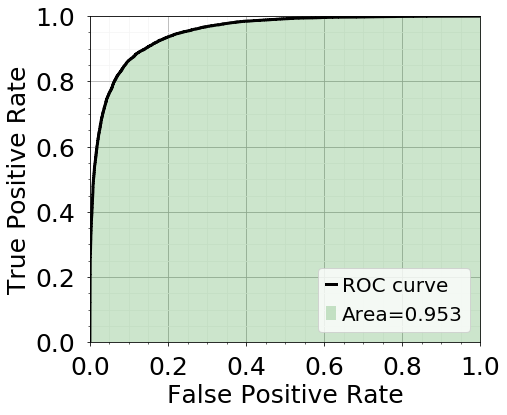

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Compute false and true positive rates
fpr, tpr, thresholds=roc_curve(y_test, method.predict_proba(X_test)[:,1], sample_weight=X_test_we)

# Area under the roc curve
roc_auc=auc(fpr, tpr)

# Plot the result
def roc_curve_plot(fpr, tpr, roc_auc, 
                   colors, linewidth, filename, 
                   plots_size=(7, 6), all_fontsize=25, withluck=False,  
                   xlab='False Positive Rate', ylab='True Positive Rate'):
    
    fig, ax=plt.subplots(figsize=plots_size)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[0], label='ROC curve', linewidth=linewidth)
    
    # Add AUC (color less points in order to decrease the figure size)
    def takeless(npndarray):
        lim=100
        dist=int(len(npndarray)/lim)
        ret=np.array([npndarray[i*dist] for i in range(lim)])
        return np.append(ret, [npndarray[-1]])
    
    ax.fill_between(takeless(fpr), takeless(tpr), alpha=.2, linewidth=0, color=colors[1], 
                    label='Area=%0.3f'%(roc_auc))

    if withluck: plt.plot([0, 1], [0, 1], '--', color=(0.4, 0.4, 0.4), linewidth=1) #, label='Random'
        
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='major', axis='both')
    ax.grid(which='minor', axis='both', color='whitesmoke')
    ax.set_axisbelow(True) 
    for em in ax.xaxis.get_majorticklabels(): em.set_y(-0.02)
    for em in ax.yaxis.get_majorticklabels(): em.set_x(-0.02)
    
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel(xlab, fontsize=all_fontsize)
    plt.ylabel(ylab, fontsize=all_fontsize)
    plt.xticks(fontsize=all_fontsize)
    plt.yticks(fontsize=all_fontsize)
    plt.legend(loc="lower right", fontsize=all_fontsize-5, handlelength=0.5, handletextpad=0.3)
    
    if filename: plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    

#ROC curve
roc_curve_plot(fpr, tpr, roc_auc, ['black', '#8abd66c2'], 3, 'ROC_curve')



#### BDT Reproducibility

In [8]:
from scipy import stats

def compare_train_test_ratio_values(clf, X_train, y_train, X_test, y_test):
    
    # Determine the BDT output on the training and test sets of the cat 1 and 2
    decisions=[]
    for X, y in ((X_train, y_train), (X_test, y_test)):
        d1=clf.predict_proba(X[y>0.5])[:,1].ravel() ##look for ones, cat 1
        d2=clf.predict_proba(X[y<0.5])[:,1].ravel() ##look for zeros cat 2
        decisions+=[d1, d2]

    # Compute the Kolmogorov-Smirnov test
    ksst1, kspv1=stats.ks_2samp(decisions[0], decisions[2]) #cat 1, train test
    ksst2, kspv2=stats.ks_2samp(decisions[1], decisions[3]) #cat 2, train test

    return [decisions, ksst1, ksst2, kspv1, kspv2]

# First, get the BDT output of the test and training sets
vals_overfit=compare_train_test_ratio_values(method, X_train, y_train, X_test, y_test)


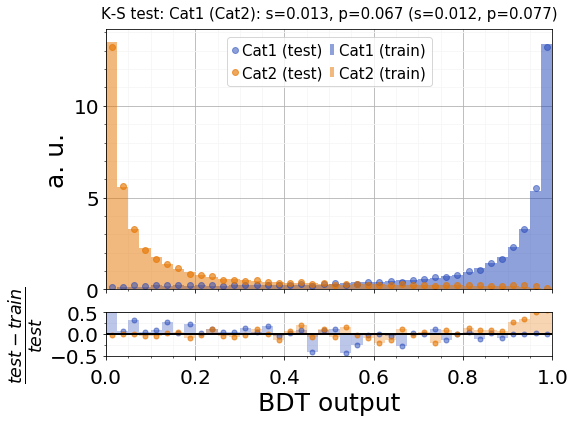

In [9]:
from uncertainties import ufloat
from uncertainties.umath import *
from matplotlib.ticker import LinearLocator


def compare_train_test_ratio_plot(list_values, label_list, colors, 
                                  yaxis, pulselim, filename,
                                  cats='S (B)', plots_size=(8, 6), all_fontsize=25, leg_fontsize=15, 
                                  bins=40, alph=0.5, yax='Events', low_high=[0, 1], 
                                  weights=4*[None], xlims_corr=[0.2, 4], ncols=2):
    
    fig, (ax, ax2)=plt.subplots(nrows=2, ncols=1, figsize=plots_size, sharex=True, 
                                gridspec_kw={'height_ratios': [6, 1]})
    
    fig.subplots_adjust(wspace=0.1, hspace=0.15)
    
    decisions, ksst1, ksst2, kspv1, kspv2 = list_values

    #plot 1 ------------------------------- signal train 
    hist_sn, bins_sn, other=ax.hist(decisions[0], color=colors[0], alpha=alph, range=low_high, bins=bins, 
                                    histtype='stepfilled', label=label_list[0], 
                                    density=True, weights=weights[0])
    width=(bins_sn[1]-bins_sn[0]); center=(bins_sn[:-1]+bins_sn[1:])/2

    scale_sn=len(decisions[0])/sum(hist_sn); err_sn=np.sqrt(hist_sn*scale_sn)/scale_sn
    val_err_sn=[ufloat(hist_sn[i], err_sn[i]) for i in range(bins)]

    #plot 2 -------------------------------- bkg train 
    hist_bn, bins_bn, other=ax.hist(decisions[1], color=colors[1], alpha=alph, range=low_high, bins=bins, 
                                    histtype='stepfilled', label=label_list[1], 
                                    density=True, weights=weights[1])
    scale_bn=len(decisions[1])/sum(hist_bn); err_bn=np.sqrt(hist_bn*scale_bn)/scale_bn
    val_err_bn=[ufloat(hist_bn[i], err_bn[i]) for i in range(bins)]

    #plot 3 ------------------------------- signal test 
    hist_st, bins_st=np.histogram(decisions[2], bins=bins, range=low_high, 
                                    density=True, weights=weights[2])
    scale_st=len(decisions[2])/sum(hist_st); err_st=np.sqrt((hist_st*scale_st).astype(float))/scale_st
    val_err_st=[ufloat(hist_st[i], err_st[i]) for i in range(bins)]
    ax.plot(center, hist_st, marker='o', c=colors[0], label=label_list[2], linestyle='None')

    #plot 4 ------------------------------- bkg test 
    hist_bt, bins_bt=np.histogram(decisions[3], bins=bins, range=low_high, 
                                    density=True, weights=weights[3])
    scale_bt=len(decisions[3])/sum(hist_bt); err_bt=np.sqrt((hist_bt*scale_bt).astype(float))/scale_bt
    val_err_bt=[ufloat(hist_bt[i], err_bt[i]) for i in range(bins)]
    ax.plot(center, hist_bt, marker='o', c=colors[1], label=label_list[3], linestyle='None')

    
    ax.set_ylabel('a. u.', fontsize=all_fontsize)
    
    ax.legend(loc='upper center', fontsize=leg_fontsize, ncol=ncols, columnspacing=0.5, 
              handlelength=0.3, handletextpad=0.3)
    
    ax.set_xlim([0, 1])
    
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.set_axisbelow(True) 
    ax.grid(which='major', axis='both')
    ax.grid(which='minor', axis='both', color='whitesmoke')
    
    if yaxis=='log': 
        ax.set_yscale(yaxis)
    if yaxis=='linear': 
        allvalues=np.concatenate((hist_sn, hist_bn, hist_st, hist_bt), axis=None)
        ax.set_ylim([0, max(allvalues)+0.05*max(allvalues)])
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    ax.tick_params(axis='x', labelsize=all_fontsize-5)
    ax.tick_params(axis='y', labelsize=all_fontsize-5)

    # Ratio below the plot
    vals_s=[]; vals_b=[]; center_s=[]; center_b=[]
    for i in range(bins):
        if hist_sn[i]!=0 and hist_st[i]!=0:
            center_s.append(center[i])
            ra_s=(val_err_st[i]-val_err_sn[i])/val_err_st[i]
            vals_s.append(ra_s.n)
        if hist_bn[i]!=0 and hist_bt[i]!=0:
            center_b.append(center[i])
            ra_b=(val_err_bt[i]-val_err_bn[i])/val_err_bt[i]
            vals_b.append(ra_b.n)

    ax2.plot(center_s, vals_s, markersize=10, marker='.', color=colors[0], linestyle='None')
    ax2.plot(center_b, vals_b, markersize=10, marker='.', color=colors[1], linestyle='None')
    
    for i in range(len(bins_sn)-1):
        ax2.fill_between([bins_sn[i], bins_sn[i+1]], vals_s[i], 0, color=colors[0], ec=colors[0], alpha=0.3, linewidth=0)
        ax2.fill_between([bins_bn[i], bins_bn[i+1]], vals_b[i], 0, color=colors[1], ec=colors[1], alpha=0.3, linewidth=0)

    ax2.plot([-1, 2], [0, 0], 'k-', lw=2)    
    
    ax2.set_xlabel("BDT output", fontsize=all_fontsize)
    ax2.set_axisbelow(True) 
    ax2.grid(which='major', axis='both')
    ax2.grid(which='minor', axis='both', color='whitesmoke')

    ax2.set_ylim([-pulselim, pulselim])
    ax2.yaxis.set_major_locator(LinearLocator(3))
    ax2.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax2.set_ylabel(r'$\frac{test - train}{test}$', size=all_fontsize)

    ax2.tick_params(axis='y', labelsize=all_fontsize-5)
    ax2.tick_params(axis='x', labelsize=all_fontsize-5)
    for em in ax2.xaxis.get_majorticklabels(): em.set_y(-0.12)

        
    # Write result of the K-S test
    setlim=3
    setlimval=1e-3
    si_ksst1='='; si_kspv1='='; si_ksst2='='; si_kspv2='='
    if ksst1<setlimval: ksst1=setlimval; si_ksst1='<'
    if kspv1<setlimval: kspv1=setlimval; si_kspv1='<'
    if ksst2<setlimval: ksst2=setlimval; si_ksst2='<'
    if kspv2<setlimval: kspv2=setlimval; si_kspv2='<'

    titl_str=("K-S test: "+cats+
              ": s"+si_ksst1+"{1:.{0}f}".format(setlim, ksst1)+
              ", p"+si_kspv1+"{1:.{0}f}".format(setlim, kspv1)+
              " (s"+si_ksst2+"{1:.{0}f}".format(setlim, ksst2)+
              ", p"+si_kspv2+"{1:.{0}f})".format(setlim, kspv2)) 

    ax.set_title(titl_str, loc='center', fontsize=all_fontsize-10, y=1.02, wrap=True)
    
    # Save figure
    if filename: plt.savefig(f"{filename}.pdf", bbox_inches='tight')

# Then, plot the test and training set
labels=[r'Cat1', 'Cat2']
labels_plot=[labels[0]+' (train)', labels[1]+' (train)', labels[0]+' (test)', labels[1]+' (test)']

#with Kolmogorov–Smirnov test on top (evaluates with a number how  much overfitting there is)
compare_train_test_ratio_plot(vals_overfit, labels_plot, ['#2145b882', '#e67500a3'], 
                              "linear", 0.5, 'Overfitting_lin', 
                              cats=labels[0]+' ('+labels[1]+')', 
                              weights=[X_train_we[y_train>0.5], X_train_we[y_train<0.5], 
                                       X_test_we[y_test>0.5], X_test_we[y_test<0.5]])




### BDT output

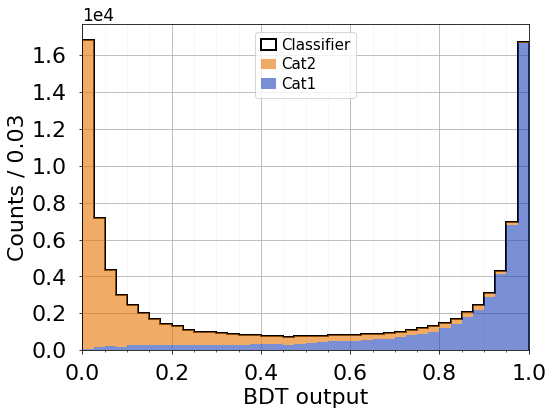

In [10]:
from matplotlib.ticker import LogLocator

def plot_classifier(list_y_predicted, nb_bins, col, lab, lab_loc, yaxis,
                    filename,
                    plots_size=(8, 6), yax='Counts', al=0.6, all_fontsize=22, leg_fontsize=15, 
                    weights=[], edgecol=None, x_range=[0, 1]):
    
    fig, ax=plt.subplots(figsize=plots_size)
    
    if not weights: weights=len(list_y_predicted)*[None]
    
    low, high=x_range
    histdiv=(high-low)/nb_bins

    plt.hist(list_y_predicted[0], color=col[0], range=[low, high], bins=nb_bins, histtype='step', 
             label=lab[0], linewidth=2, weights=weights[0])
    
    if len(list_y_predicted)>1:
        plt.hist(list_y_predicted[1:], color=col[1:], range=[low, high], bins=nb_bins, histtype='stepfilled', 
                 label=lab[1:], linewidth=1, weights=weights[1:], alpha=al, stacked=True, edgecolor=edgecol)
        
    plt.xlabel("BDT output", fontsize=all_fontsize)
    plt.ylabel(yax+' / %0.2f'%(histdiv), fontsize=all_fontsize)
    plt.legend(loc=lab_loc, fontsize=leg_fontsize, handlelength=1, handletextpad=0.3, labelspacing=0.3)
    plt.xticks(fontsize=all_fontsize)
    plt.yticks(fontsize=all_fontsize)
    
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    
    ax.set_xlim(x_range)
    ax.set_yscale(yaxis)
    if yaxis=='log': 
        ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    elif yaxis=='linear': 
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        t=ax.yaxis.get_offset_text()
        t.set_fontsize(all_fontsize-5)
    for em in ax.xaxis.get_majorticklabels(): em.set_y(-0.02)
    for em in ax.yaxis.get_majorticklabels(): em.set_x(-0.02)
        
    ax.set_axisbelow(True)
    ax.grid(which='major', axis='both')
    ax.grid(which='minor', axis='both', color='whitesmoke')
    
    if filename: plt.savefig(f"{filename}.pdf", bbox_inches='tight')




decision_X=method.predict_proba(X[:,0:-2])[:,1]
decision_cat1=method.predict_proba(df_cat1[df_cat1.columns[:-2]])[:,1]
decision_cat2=method.predict_proba(df_cat2[df_cat2.columns[:-2]])[:,1]


X_wei=X[:,list(df_cat1.columns).index(wei)]
df_cat1_wei=df_cat1[wei].to_numpy()
df_cat2_wei=df_cat2[wei].to_numpy()


leg_class=['Classifier', 'Cat1', 'Cat2']

plot_classifier([decision_X, decision_cat1, decision_cat2], 40, ['black', '#2145b882', '#e67500a3'], 
                leg_class, 'upper center', 'linear', 'Classifier_stack_lin', 
                weights=[X_wei, df_cat1_wei, df_cat2_wei])



### Save the Dataframe with the BDT output saved as a column

In [11]:
# Add the BDT output column
df['Basic_BDT_output']=method.predict_proba(df[df.columns[:-2]])[:,1].tolist()

# Print the Dataframe
print(df)

# Save the Dataframe
pickle.dump(df, open(f'dataset_2classes_basicBDT.pkl', "wb"))

              a         b          c    d         e         f    g         h  \
0      3.863403  0.778973  12.946646  489  0.871213  0.033967  227  0.981583   
1      5.046944 -0.442038  23.305970  509  0.600349  3.773768  234  0.513771   
2      6.446498  1.500218  17.340156  504  2.235587  0.166467  251  2.038727   
3      7.555237  0.227320   7.548010  486  3.726162  1.393235  251  0.522864   
4      5.849820  1.143522   8.982487  477  7.757577  0.414826  239  2.865683   
...         ...       ...        ...  ...       ...       ...  ...       ...   
99995  5.291775 -0.449244   1.298263  460  7.275139  0.676796  280  1.019964   
99996  6.696291  3.010353  14.831392  506  1.125645  0.116567  272  0.921327   
99997  6.532237 -0.278088   3.923387  492  8.262313  0.172891  249  1.378034   
99998  5.213979  0.505269  22.187842  509  2.441799  0.610413  254  0.485675   
99999  7.748984  2.195952   9.598227  516  0.685071  1.201439  271  2.616782   

              i         j  dataset  wei